In [1]:
%%capture
! pip install -U gym[atari]

In [2]:
%%capture
%%bash

# This is for saving videos of the environment in Google Colab
apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
pip install -U colabgymrender

In [3]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from colabgymrender.recorder import Recorder

sns.set_context("talk")

# Solving the MountainCar problem using Q-learning

## Creating the environment

In [4]:
# Create environment
env = gym.make("MountainCar-v0")

# Use this if you want to visualize the environment in Google Colab
directory = './video'
env = Recorder(env, directory)

In [5]:
env.action_space

Discrete(3)

In [6]:
env.observation_space

Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)

In [7]:
env.goal_position

0.5

In [8]:
env.reset()

done = False
while not done:
  action = 2
  new_state, reward, done, _ = env.step(action)
env.play()

array([-0.41817367,  0.        ])

100%|█████████▉| 201/202 [00:00<00:00, 293.98it/s]


## Discretization

The MountainCar environment has continous observation state by default. Here, we have to change the continuous range describing our environment into discrete states that can be used by Markov Decision Processes with reasonable size. We will start by splitting each of the two dimension into 20 discrete state, for a total of $20 * 20 = 400$ possible observation state.

In [9]:
# Maximum and minimum values for dimension 1 and 2
print(env.observation_space.high)
print(env.observation_space.low)

[0.6  0.07]
[-1.2  -0.07]


In [10]:
DISCRETE_SIZE = [20, 20]  # A 20 by 20 table
discrete_win_size = (env.observation_space.high - env.observation_space.low) / DISCRETE_SIZE
discrete_win_size  # length of each discrete state

array([0.09 , 0.007])

The function below will be used to discretize the observation states automatically, taking a continuous state as input and returnin a tuple of discrete states.

In [11]:
def get_discrete(state):
  discrete_state = (state - env.observation_space.low) / discrete_win_size
  return tuple(discrete_state.astype(np.int))

In [12]:
discrete_state = get_discrete(env.reset())

In [13]:
(action, )

(2,)

In [14]:
discrete_state + (action, )

(8, 10, 2)

## Creating the Q-table

In [15]:
q_table = np.random.uniform(low=-2, high=0, size=(DISCRETE_SIZE + [env.action_space.n]))

In [16]:
q_table.shape  # All the observation state + the 3 possible actions

(20, 20, 3)

In [17]:
q_table[discrete_state]

array([-1.89294866, -1.71751264, -0.48252825])

The core of the Q-learning algorithm is the value iteration update based on the [Bellman equation](https://en.wikipedia.org/wiki/Bellman_equation). It uses the weighted average of old values and new information:

$$ Q(S_{t}, A_{t}) \leftarrow Q(S_{t}, A_{t}) + \alpha [R_{t+1} + \gamma max_{a} Q(S_{t+1}, a) - Q(S_{t}, A_{t})] $$

The code below will run one episode (run the environment until the final state is reached or the maximum time has elapsed). At each step, the agent:
1. Select the best action to perform in the q-table
2. Get the reward and new state from the environment.
3. Update the Q-table for the current state, given the reward from the future state.
4. Go to the next state.

In [18]:
LEARNING_RATE = 0.1
DISCOUNT = 0.95
EPISODES = 10000

discrete_state = get_discrete(env.reset())
done = False
while not done:

  # 1 - Select action
  action = np.argmax(q_table[discrete_state])

  # 2 - Step
  new_state, reward, done, _ = env.step(action)

  # Discretize state
  new_discrete_state = get_discrete(new_state)

  if not done:
    max_future_q = np.max(q_table[new_discrete_state])
    current_q = q_table[discrete_state + (action, )]

    # 3 - Update function
    new_q = current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q - current_q)
    q_table[discrete_state + (action, )] = new_q
  
  # If final state reached
  elif new_state[0] >= env.goal_position:
    q_table[discrete_state + (action, )] = 0

  # 4 - The next state if passed to the next iteration
  discrete_state = new_discrete_state

env.play()

100%|█████████▉| 201/202 [00:00<00:00, 302.04it/s]


If we want that the agent starts learning from previous episodes, we should simply continue to update the Q-table at each iteration while running many episodes. To visualize how the agent is improving through time, we will store the cumulative return at the end of each episode.

In [19]:
env = gym.make("MountainCar-v0")

EPISODES = 2000
q_table = np.random.uniform(low=-2, high=0, size=(DISCRETE_SIZE + [env.action_space.n]))

cumulative_return = []
for episode in range(EPISODES):
  discrete_state = get_discrete(env.reset())
  done = False

  episode_return = []
  while not done:

    # Select action
    action = np.argmax(q_table[discrete_state])

    # Step
    new_state, reward, done, _ = env.step(action)

    # Update episode return
    episode_return.append(reward)

    # Next state
    new_discrete_state = get_discrete(new_state)

    if not done:
      max_future_q = np.max(q_table[new_discrete_state])
      current_q = q_table[discrete_state + (action, )]

      # Update function
      new_q = current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q - current_q)
      q_table[discrete_state + (action, )] = new_q
    
    # If final state reached
    elif new_state[0] >= env.goal_position:
      q_table[discrete_state + (action, )] = 0

    discrete_state = new_discrete_state

  cumulative_return.append(sum(episode_return))

  # Print the cumulative rewar every 100 episodes
  if episode % 200 == 0:
    print(f"Cumulative reward: {sum(episode_return)} - Episode: {episode}")

Cumulative reward: -200.0 - Episode: 0
Cumulative reward: -200.0 - Episode: 200
Cumulative reward: -200.0 - Episode: 400
Cumulative reward: -200.0 - Episode: 600
Cumulative reward: -200.0 - Episode: 800
Cumulative reward: -200.0 - Episode: 1000
Cumulative reward: -200.0 - Episode: 1200
Cumulative reward: -200.0 - Episode: 1400
Cumulative reward: -153.0 - Episode: 1600
Cumulative reward: -200.0 - Episode: 1800


<Figure size 1296x360 with 0 Axes>

Text(0, 0.5, 'Cumulative return')

Text(0.5, 0, 'Block of 200 episodes')

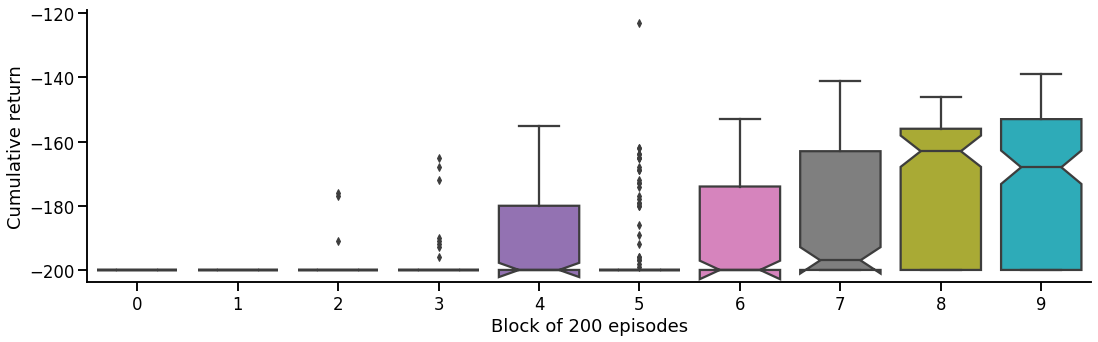

In [20]:
plt.figure(figsize=(18, 5))
all_rewards = [cumulative_return[i:i+200] for i in range(0, len(cumulative_return), 200)]
sns.boxplot(data=all_rewards, notch=True)
plt.ylabel("Cumulative return")
plt.xlabel("Block of 200 episodes")
sns.despine()

We can watch the performance of the agent after the learning by playing one more episode and saving the video.

In [21]:
done = False

env = gym.make("MountainCar-v0")
directory = './video'
env = Recorder(env, directory)

discrete_state = get_discrete(env.reset())

while not done:

  # Select action
  action = np.argmax(q_table[discrete_state])

  # Step
  new_state, reward, done, _ = env.step(action)

  # Next state
  new_discrete_state = get_discrete(new_state)

  if not done:
    max_future_q = np.max(q_table[new_discrete_state])
    current_q = q_table[discrete_state + (action, )]

    # Update function
    new_q = current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q - current_q)
    q_table[discrete_state + (action, )] = new_q
  
  # If final state reached
  elif new_state[0] >= env.goal_position:
    q_table[discrete_state + (action, )] = 0

  discrete_state = new_discrete_state

env.play()

100%|██████████| 166/166 [00:00<00:00, 289.48it/s]


Use an $\epsilon$ parameter to control the greediness of our agent. The agent will chose the optimized behavior with probability 1-$\epsilon$. The value of $\epsilon$ will also change across time, slowly decaying so the agent is progressively adopting the best behavior.

In [22]:
epsilon = 0.5
START_EPSILON_DECAY = 1
END_EPSILON_DECAY = 15000
epsilon_decay = epsilon/(END_EPSILON_DECAY - START_EPSILON_DECAY)

In [23]:
env = gym.make("MountainCar-v0")

EPISODES = 20000
LEARNING_RATE = 0.1
DISCOUNT = 0.95

q_table = np.random.uniform(low=-2, high=0, size=(DISCRETE_SIZE + [env.action_space.n]))

cumulative_return = []
for episode in range(EPISODES):
  discrete_state = get_discrete(env.reset())
  done = False

  episode_return = []
  while not done:

    # Select action based on the epsilon policy
    if np.random.random() > epsilon:
      action = np.argmax(q_table[discrete_state])
    else:
      action = np.random.randint(0, env.action_space.n)

    # Step
    new_state, reward, done, _ = env.step(action)

    # Update episode return
    episode_return.append(reward)

    # Next state
    new_discrete_state = get_discrete(new_state)

    if not done:
      max_future_q = np.max(q_table[new_discrete_state])
      current_q = q_table[discrete_state + (action, )]

      # Update function
      new_q = current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q - current_q)
      q_table[discrete_state + (action, )] = new_q
    
    # If final state reached
    elif new_state[0] >= env.goal_position:
      q_table[discrete_state + (action, )] = 0

    discrete_state = new_discrete_state

  cumulative_return.append(sum(episode_return))

  # Decaying epsilon
  if END_EPSILON_DECAY >= episode >= START_EPSILON_DECAY:
    epsilon -= epsilon_decay

  # Print the cumulative rewar every 100 episodes
  if episode % 1000 == 0:
    print(f"Cumulative reward: {sum(episode_return)} - Episode: {episode}")

Cumulative reward: -200.0 - Episode: 0
Cumulative reward: -200.0 - Episode: 1000
Cumulative reward: -200.0 - Episode: 2000
Cumulative reward: -175.0 - Episode: 3000
Cumulative reward: -200.0 - Episode: 4000
Cumulative reward: -200.0 - Episode: 5000
Cumulative reward: -200.0 - Episode: 6000
Cumulative reward: -200.0 - Episode: 7000
Cumulative reward: -200.0 - Episode: 8000
Cumulative reward: -169.0 - Episode: 9000
Cumulative reward: -200.0 - Episode: 10000
Cumulative reward: -153.0 - Episode: 11000
Cumulative reward: -182.0 - Episode: 12000
Cumulative reward: -145.0 - Episode: 13000
Cumulative reward: -141.0 - Episode: 14000
Cumulative reward: -167.0 - Episode: 15000
Cumulative reward: -155.0 - Episode: 16000
Cumulative reward: -149.0 - Episode: 17000
Cumulative reward: -155.0 - Episode: 18000
Cumulative reward: -113.0 - Episode: 19000


# Analyzing the performance of the Q-learning algorithm

<Figure size 1296x360 with 0 Axes>

Text(0, 0.5, 'Cumulative return')

Text(0.5, 0, 'Block of 500 episodes')

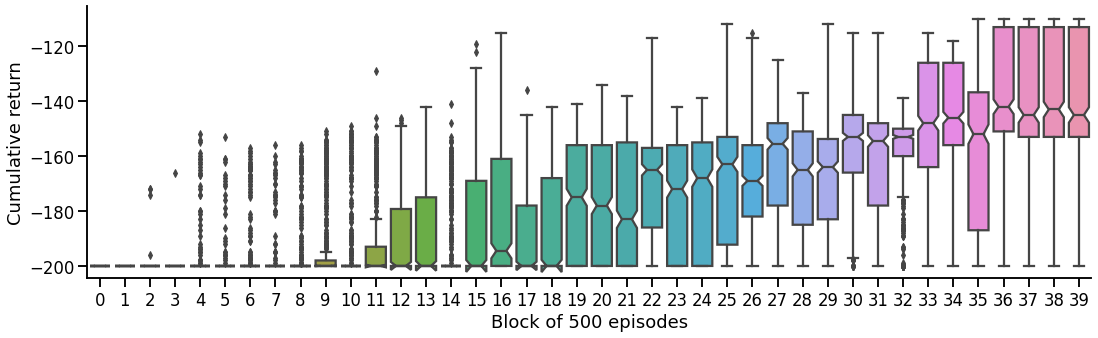

In [24]:
plt.figure(figsize=(18, 5))
all_rewards = [cumulative_return[i:i+500] for i in range(0, len(cumulative_return), 500)]
sns.boxplot(data=all_rewards, notch=True)
plt.ylabel("Cumulative return")
plt.xlabel("Block of 500 episodes")
sns.despine()

Text(0.5, 1.0, 'Action 0')

Text(0.5, 0, 'State dimension 1')

Text(0.5, 1.0, 'Action 1')

Text(0.5, 0, 'State dimension 1')

Text(0.5, 1.0, 'Action 2')

Text(0.5, 0, 'State dimension 1')

Text(0, 0.5, 'State dimension 2')

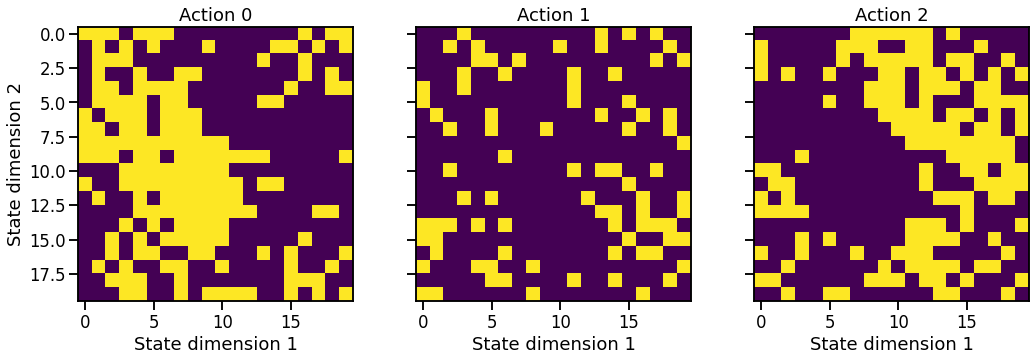

In [25]:
 _, axs = plt.subplots(ncols=env.action_space.n, figsize=(15, 5), sharey=True)
for i in range(env.action_space.n):
  axs[i].imshow(q_table[:, :, i] == np.max(q_table[:, :, :], axis=2))
  axs[i].set_title(f"Action {i}")
  axs[i].set_xlabel("State dimension 1")
axs[0].set_ylabel("State dimension 2")
plt.tight_layout()